In [175]:
import numpy as np
import matplotlib.pyplot as plt
import time
from igraph import Graph
import networkx as nx
from joblib import Parallel, delayed
from scipy.optimize import fsolve
from numba import njit, int64, float64, prange
import timeit
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.patches as patches
from scipy import stats

# Problem 1: Sampling from the ensamble

## Sampling algorithm

A good data-structure for sparse matrices is **edge list**.
Let N the number of nodes and M the number of edges, then different datastructures memory needed scales in the following way

- Adjacency Matrix $O(N^2)$ 
- Adjacency list $O(NM)$ 
- Edge list or edge set $O(M)$

for a sparse grapgh $M\sim O(N)$  the edgelist is more convenient
In this ensamble in particular $N \le M\le 4N$

In particular I sample directly the edgelists of the graphs


In [2]:
def sample_mask_list(N,pi):

    # fix number of spins for each connectivity: round to have graphical degree sequences
    N1 = int((1-pi)*N)
    if N1%2!=0:
        N1+=1
    N4 = N-N1
    Ntot = N1+4*N4

    # create a list containing half edges
    d = np.zeros(Ntot,dtype=np.int64)
    for i in range(N1):
        d[i]=i
    for j in range(N1,Ntot):
        d[j] = (j-N1)//4+N1
    
    # initialize a mask to control which half edges have been already coupled
    mask = np.ones_like(d)

    # I sample the edge-list (el)
    # Being the graphs sparse el is the optimal structure to keep them
    # O(M) vs O(N^2) for adjacency matrix vs O(N*M) for adjacency list
    edgeList=[]
    haltCount=0

    # while all the edges are not coupled
    while np.sum(mask)>0:

        # this piece of code is needed because, in particular for small N,
        # the algorithm may end up with the last two edges being a self-edge
        # or forming an edge that is already in the list:
        # If it get stuck at the end it start sampling again
        if np.sum(mask)==2:
            haltCount+=1
            if haltCount >3:
                mask = np.ones_like(d)
                edgeList = []
                i = 0
                haltCount=0

        # sample two half-edges from the remaining ones --> sorted tuple to check easier double edges
        drawn = tuple(sorted(tuple(np.random.choice(d[mask==1],2,replace=False))))

        # Check if it is an edge that can be added, in case it is added otherwise sample again
        if drawn[0] != drawn[1] and drawn not in edgeList:
            edgeList.append(drawn)

            # update the mask for the half-edges already taken
            for elm in drawn:
                if elm<N1:
                    mask[elm]=0
                else:
                    ip = N1+(elm-N1)*4
                    s = np.sum(mask[ip:ip+4])
                    mask[ip+4-s] = 0

    # return the edgelist a list of ordered tuples
    return edgeList

# A small function to check if sample correctly without repeated edges
def has_duplicates(arr):
    return len(arr) != len(set(arr))

# A small function to check that it doesn't have self-edges (loops)
def has_loops(arr):
    for elm in arr:
        if elm[0] == elm[1]:
            return True
    return False

In [3]:
# Plot the graph
def plot_graph(el,pi):

    # Create a new graph from the edge list
    G = nx.Graph()
    G.add_edges_from(el)

    # Draw the graph
    plt.figure(figsize=(6, 4))
    nx.draw(G, with_labels=False, node_color='skyblue', node_size=10, 
            edge_color='k', linewidths=1, font_size=15, 
            arrows=True, arrowsize=20)
    plt.title(fr"$\pi =$ {pi}")
    plt.savefig(f"example_pi_{pi}.png")
    plt.show()

In [4]:
def plot_graphs_in_grid(edge_lists):
    # Validate input
    if len(edge_lists) != 8:
        raise ValueError("Expected exactly 8 edge lists")
    
    # Setup the figure and axes for a 2x4 grid of plots
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))
    axes = axes.flatten()  # Flatten for easy iteration
    
    for i, el in enumerate(edge_lists):
        G = nx.Graph()
        G.add_edges_from(el)
        ax = axes[i]
        nx.draw(G, ax=ax, with_labels=False, node_color='skyblue', node_size=50,
                edge_color='k', linewidths=1, font_size=15)
        ax.set_title(fr"$\pi$ = {(i/10.):.1f}",fontsize=16)
        ax.axis('off')  # Turn off the axis
        
        # Drawing a black rectangle border around the subplot
        rect = patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none', transform=ax.transAxes, clip_on=False)
        ax.add_patch(rect)
        
    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.savefig("graphs_grid_with_borders.png")
    plt.show()

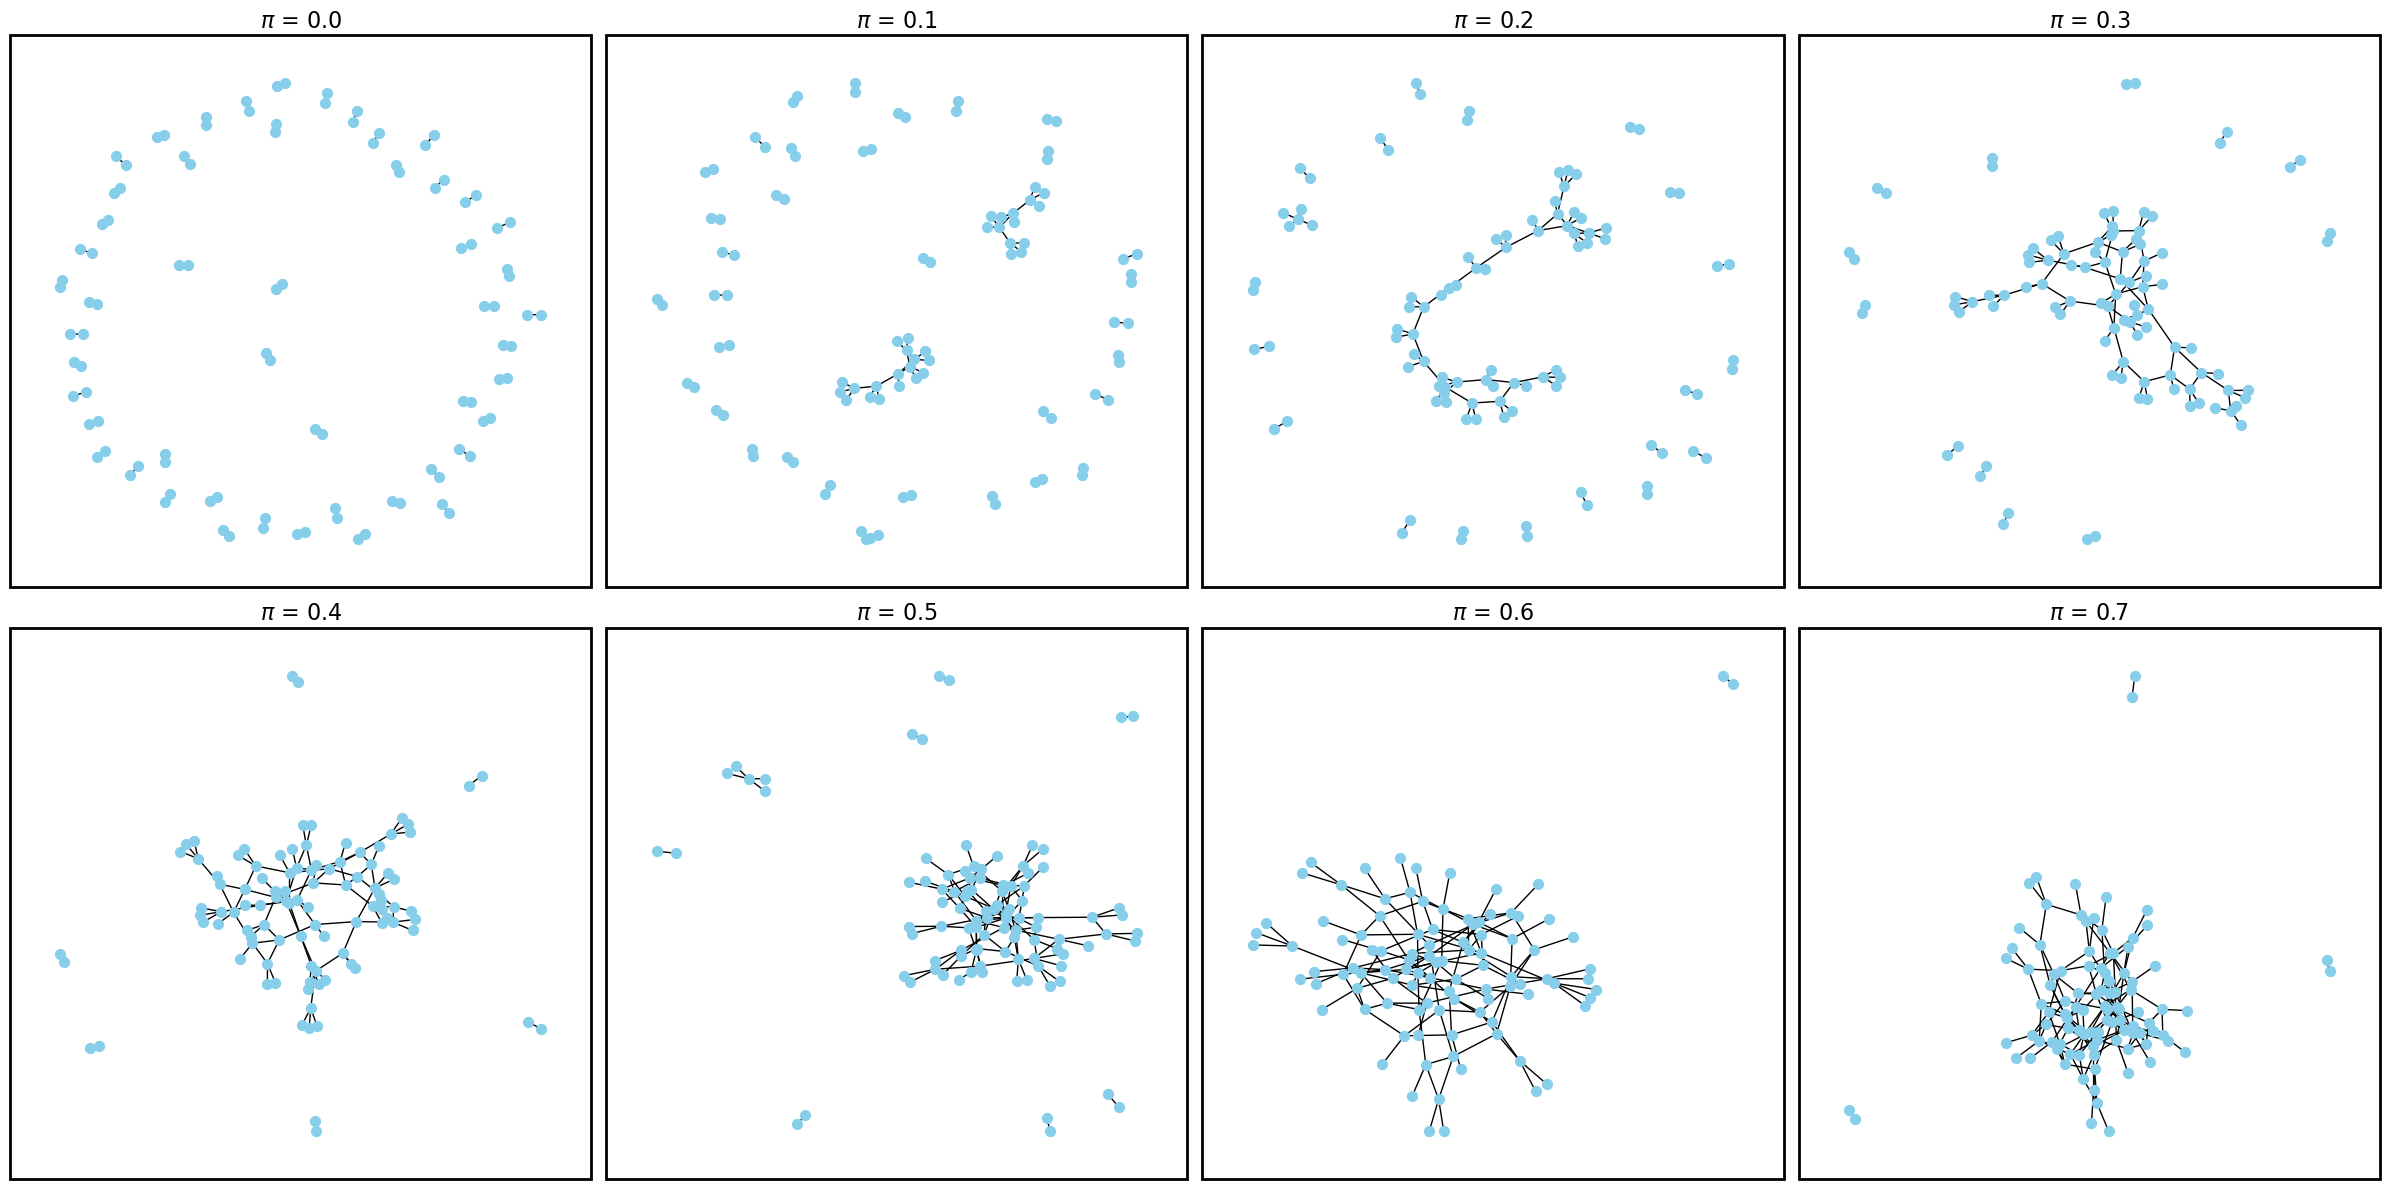

In [8]:
N = 100
pi_values = [i * 0.1 for i in range(8)]
els = [sample_mask_list(N,pi) for pi in pi_values]
plot_graphs_in_grid(els)

The following cell is to test the functionality and to visulize the typical instances generated

pi = 0.0
Has duplicates? False
Has loops? False


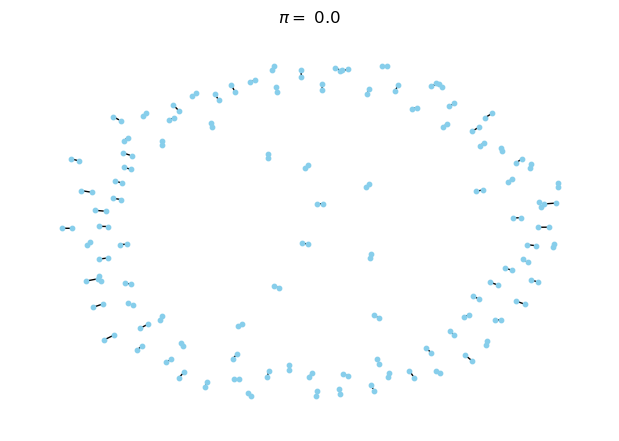

400
pi = 1
Has duplicates? False
Has loops? False


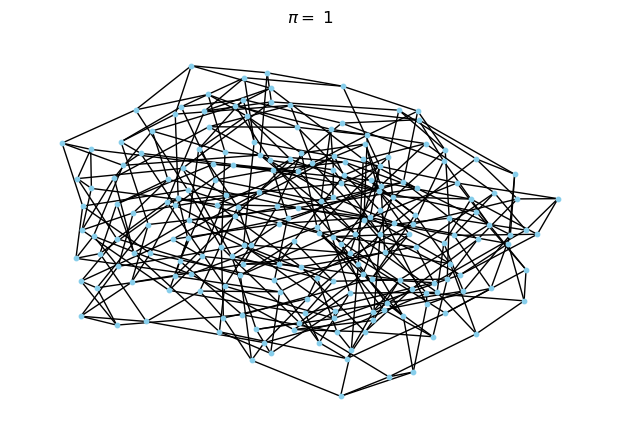

In [50]:
N = 200

# See a graph with pi = 0.1
pi = 0.0
el_01 = sample_mask_list(N,pi)
print(f"pi = {pi}")
print(f"Has duplicates? {has_duplicates(el_01)}\nHas loops? {has_loops(el_01)}")
plot_graph(el_01,pi)

# See a graph with pi = 0.9
pi = 1
el_09 = sample_mask_list(N,pi)
print(len(el_09))
print(f"pi = {pi}")
print(f"Has duplicates? {has_duplicates(el_09)}\nHas loops? {has_loops(el_09)}")
plot_graph(el_09,pi)

## Sampling a lot!

I decided to sample many edgelist for the subsequent analyses and store them in files.
In particular I chose 3 different values of N $\in \{100,1000,10000\}$
For each N I sampled 100 instances for 200 different values of $\pi$ eavenly spaced in [0,1]

The sampling N = 1000, 10000 is very long so the code is commented so that you don't run by accident.

In [ ]:
N = 100
n = 100
Pis = 200
Pi = np.linspace(0,1,Pis,endpoint=True)
for j, pi in enumerate(Pi):
    # print(pi)

    # sampling in parallel in all the cores to have better performances
    gs = Parallel(n_jobs=-1)(delayed(sample_mask_list)(N,pi) for i in range(n))

    # write on file
    with open("grafi100.txt","a") as f:
        for i, elm in enumerate(gs):
            f.write(f"{N},{pi},{Pis}\n")
            for k in elm:
                f.write(f"{k}\n")
            f.write("\n")
            
with open("grafi100.txt","a") as f:
    f.write("\n")

In [ ]:
"""
N = 1000
n = 100
Pis = 200
Pi = np.linspace(0,1,Pis,endpoint=True)
for j, pi in enumerate(Pi):
    print(pi)
    gs = Parallel(n_jobs=-1,verbose=5)(delayed(sample_mask_list)(N,pi) for i in range(n))
    with open("grafi1000.txt","a") as f:
        for i, elm in enumerate(gs):
            f.write(f"{N},{pi},{Pis}\n")
            for k in elm:
                f.write(f"{k}\n")
            f.write("\n")
            
with open("grafi1000.txt","a") as f:
    f.write("\n")
"""

In [ ]:
"""
N = 10000
n = 100
Pis = 200
Pi = np.linspace(0,1,Pis,endpoint=True)
for j, pi in enumerate(Pi):
    gs = Parallel(n_jobs=-1,verbose=5)(delayed(sample_mask_list)(N,pi) for i in range(n))
    with open("grafi10000.txt","a") as f:
        for i, elm in enumerate(gs):
            f.write(f"{N},{pi},{Pis}\n")
            for k in elm:
                f.write(f"{k}\n")
            f.write("\n")
            
with open("grafi10000.txt","a") as f:
    f.write("\n")
"""

# Problem 2 and 3: Giant connected component and 3-core

The idea is to read the graphs from file and compute the size of the greatest connected component and the size of the 3-core and store only these data, the computation indeed is really long (1140') for N = 10^4.

The idea is to implement Breadth-first-search (bfs) and keep only the size fo the largest component. This algorithm need the adjacency list to work...

### From edge lists to adjacency lists

In [5]:
# Algorithm to go from the edgelist to the adjacency list (al) representation of a graph istance
def el_al(el,N,how="dict"):

    # initialize al as a np.array of -1 (N,4) 4 is the maximum degree for the ensamble
    al = -1*np.ones((N,4),dtype=int)

    # loop over all the nodes
    for i in range(N):
        j = 0

        # loop over all the edges to see which nodes are connected to the ith
        # and update the al in i
        for edge in el:
            if i in edge:
                if edge[0] == i:
                    al[i,j] = edge[1]
                else:
                    al[i,j] = edge[0]
                j+=1
    
    # different option to return the al
    # return directly the numpy array
    if how == "np":
        return al

    # return list of list
    elif how == "ll":
        lal=[]
        for i in range(N):
            riga = al[i,:]
            lal.append(list(riga[riga>=0]))
        return lal

    # return a dictonary of lists
    elif how == "dict":
        lal = dict()
        for i in range(N):
            riga = al[i,:]
            lal[i]=list(riga[riga>=0])
        return lal

    # return a dictonary of numpy arrays
    elif how == "dict_np":
        lal = dict()
        for i in range(N):
            riga = al[i,:]
            lal[i]=riga[riga>=0]
        return lal
        

### Bredth-first-search for Largest connected component (LCC)

The following are **two versions** of the algorithm to find the greatest connected componet, they use the **same logic**, that can be read from the comments on the first implementation below (__bsf_full__) but the second is written with __numba__ to be precompiled and hence faster. Numba doesn't allow all the python datastructures so the logic have been rewritten using numpy arrays only (almost)

In [6]:
# This is the algorithm for the largest connected component
# a variation of bsf
def bfs_full(al,N,how="fast",allccs=False):
    
    # create a list of length N: 0 for node deg = 1, 1 for node deg = 4
    # needed to find faster the largest connected component
    # idea is to look first for connceted components that contains at least a 
    # mode of degree 4 because for sure the largest will contain them
    where4 = np.zeros(N,dtype=int)
    for i in range(al.shape[0]):
        prov = al[i]
        d = prov[prov>=0].shape[0]
        if d>3:
            where4[i] = 1
    
    # list of nodes
    V = np.arange(N)

    # initialize a list containing the connected components
    CCs = []

    # initialize a list that it will contain the sizes of the components
    how_many = []

    # dimesion of the largest initialized to -1
    biggest_dim = -1

    # mask of ones for elements not already added to a component
    not_inc = np.ones(N,dtype=int)
    i = -1

    # loop until find all connecetd components (or find the largest before)
    while np.sum(not_inc) > 0:
        
        # I start searching form the first node that has degree 4 and it has not yet been added if it exist one
        # I expect nodes of degree 4 be in the greatest cc
        to_start_4 = V[np.multiply(not_inc,where4)==1]
        if to_start_4.any():
            s = to_start_4[0]
        else:
            s = V[not_inc == 1][0]

        # initialize the list with edges added to the component the previous step
        dC=[s]

        # initialize the size of the new componet to 1
        how_many.append(1)

        # update the mask
        not_inc[s] = 0

        # add the starting node to the list of all CCs
        CCs.append(dC)

        i+=1
        # until at the last step I do not add any more nodes to the present component
        while dC:

            # initialize list of node to add to the component at this step
            dC1 = []

            # check in all neighbors of the nodes added at the previous step
            # if some neighbors are in the same component and add them to dC1 and update the mask
            for v in dC:
                neig = al[v]
                neig = neig[neig >= 0]
                for w in neig:
                    if not_inc[w]==1:
                        not_inc[w]=0
                        dC1.append(w)
            
            # add nodes to the present connected component
            CCs[i]=CCs[i]+dC1

            # update the size of the component
            how_many[i]+=len(dC1)

            # update which are added at last step before going on
            dC = dC1

        # update size of biggest dimension
        if len(CCs[i]) > biggest_dim:
            biggest_dim = len(CCs[i])

        # if mode fast return the biggest dimesion as soon as is bigger than the nodes not checked
        if how == "fast":
            if np.sum(not_inc) <= biggest_dim: # it should be faster on larger graph 
                return biggest_dim 

    how_many = np.array(how_many)

    # otherwise return the sizes of all or the connected componets
    if allccs:
        return how_many
    else:
        return CCs, how_many

The faster one

In [7]:
@njit(int64(int64[:, :], int64))
def bfs_full_fast(al, N):

    # to store sizes of connected components
    how_many = np.zeros(N, dtype=np.int64) 
    biggest_dim = -1

    # mask to keep track of node already assigned
    not_inc = np.ones(N, dtype=np.int8) 
    ic = 0

    while np.sum(not_inc) > 0:
        # it starts from the first found already in connected component
        s = np.where(not_inc == 1)[0][0]
        dC = np.zeros(N, dtype=np.int8)
        dC[s] = 1
        not_inc[s] = 0
        how_many[ic]+=1

        # usual bsf logic
        while np.sum(dC) > 0:
            dC1 = np.zeros(N, dtype=np.int8)
            for v in np.where(dC == 1)[0]:
                neig = al[v]
                neig = neig[neig >= 0]
                for w in neig:
                    if not_inc[w] == 1:
                        not_inc[w] = 0
                        dC1[w] = 1

            how_many[ic] += np.sum(dC1)
            dC = dC1

        if how_many[ic] > biggest_dim:
            biggest_dim = how_many[ic]
        ic += 1
        # early stop
        if np.sum(not_inc) <= biggest_dim: 
            break 

    return biggest_dim

they produce the same result

In [12]:
bfs_full(el_al(el_01,N,how="np"),N), bfs_full_fast(el_al(el_01,N,how="np"),N)

NameError: name 'el_01' is not defined

The following is just to compare the speed

In [13]:
N = 1000
pi = 0.8
el = sample_mask_list(N,pi)
al = el_al(el,N,how="np")
%timeit bfs_full(al,N)
%timeit bfs_full_fast(al,N)

7.94 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
69.6 µs ± 201 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Algorithm for the q-core

Now the algorithm for the q-core, firstly I implemented a version in python vanilla (find_q_core), the logic is described in the comments on the code.

The other two version use numba, in particular the version __naive__ is it slightly less fast than the __fast__, but the logic is the same that can be easly read in __find_q_core__.


In [8]:
def find_q_core(el,q, N):
    al = el_al(el, N)
    # al as a dictionary of lists

    # create a copy of the adjacency list to modify into the q_core
    # this logic is just to be sure to have an hard copy
    q_core = {}
    for key in al:
        q_core[key] = al[key]
    
    # I create a list with all the nodes to be removed according to their connectivity
    # I also create a set with the same nodes
    to_remove = [node for node in al if len(al[node])<q]
    in_to_remove = set(to_remove)

    # while to_remove is not empty
    while to_remove:

        # I take the fisrt node form those to be removed and I remove it
        node = to_remove.pop(0)

        # update the adjacency list the q_core after removal
        for neigh in q_core[node]:

            # I remove the node in the al of adjacent nodes
            q_core[neigh].remove(node) 

            # and I check if after the removal adjacent nodes become to be removed
            if len(q_core[neigh]) < q and neigh not in in_to_remove: 
                to_remove.append(neigh)
                in_to_remove.add(neigh) # con il set se già è segnato come da rimuovere non lo aggiungo davvero di nuovo
        del q_core[node] # elimino l'entrata dal dizionario

    return len(q_core.keys())

In [9]:
@njit(int64[:,:](int64[:,:],int64))
def remove(q_core,i):
    N = q_core.shape[0]
    d = q_core.shape[1]
    for k in range(N):
        for l in range(d):
            if q_core[k,l] == i:
                q_core[k,l] = -1
    return q_core


@njit(int64(int64[:,:],int64,int64))
def q_core_numba_naive(al,q,N):
    # al is a numpy array
    q_core = al.copy()
    to_remove = np.ones(N)
    # mask for those to be removed
    changes = 1
    while changes > 0:
        changes = 0
        # inefficient loop over all nodes until changes = 0
        for i in range(N):
            neig = q_core[i,:]
            neig = neig[neig>=0]
            if neig.shape[0] < q:
                if to_remove[i] == 1:
                    to_remove[i] = 0
                    changes+=1
                    q_core = remove(q_core,i)
    return to_remove.sum()


In [16]:
@njit
def find_neighbors(node, q_core):
    # Find the valid neighbors of a node (ignoring -1 entries) due to al is a numpy array
    return q_core[node][q_core[node] >= 0]

@njit
def update_degrees_and_check(node, q_core, q, to_remove):
    # Update degrees after a node removal and mark new nodes for removal if necessary
    neighbors = find_neighbors(node, q_core)
    for neighbor in neighbors:
        q_core[neighbor, q_core[neighbor] == node] = -1  # Remove connection to the node
        if (q_core[neighbor] >= 0).sum() < q and not to_remove[neighbor]:
            to_remove[neighbor] = 1  # Mark neighbor for removal if degree falls below q

@njit(int64(int64[:,:],int64,int64))
def q_core_numba_fast(al, q, N):
    # same logic of the vanilla version
    q_core = al.copy()
    to_remove = np.zeros(N, dtype=np.int64)
    removed = np.zeros(N, dtype=np.int64)
    
    # Initial pass to determine which nodes should be marked for removal
    for i in range(N):
        if (q_core[i] >= 0).sum() < q:
            to_remove[i] = 1
    
    # Main loop for removing nodes and updating the graph
    while np.any(to_remove):
        for i in range(N):
            if to_remove[i]:
                removed[i] = 1  # Mark as removed
                to_remove[i] = 0  # Clear the removal mask
                update_degrees_and_check(i, q_core, q, to_remove)
    
    # The result can either be the count of nodes not removed or the actual q-core graph
    # Returning the count of nodes not removed
    return N - removed.sum()


In [17]:
N=1000
pi = 0.8
el = sample_mask_list(N,pi)
al = el_al(el,N,how="np")

print(find_q_core(el,3,N), q_core_numba_naive(al,3,N), q_core_numba_fast(al,3,N))

776 776 776


The following is just to test the speed

In [28]:
%timeit find_q_core(el,3,N)
%timeit q_core_numba_naive(al,3,N)
%timeit q_core_numba_fast(al,3,N) # more then 1000 times faster than the first!!!

104 ms ± 895 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
719 µs ± 8.06 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
78.7 µs ± 502 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Computing the sizes of the largest componet and 3-cores

Now for each N I open the respective file and I compute both the biggest connected component and 3-core size.

**EXECUTION TIMES ARE REALLY LONG, DO NOT RUN THE CODES**
files with the graphs are not even present because too large to stay on github. We import directly the sizes computed.

The code is just to show you how it works and if don't believe me you can try the N = 100 case


In [56]:
# open the files and compute the sizes of the biggest connected components
# and the 3 core sizes
n=100
CCs = np.zeros((200,100))
cores = np.zeros((200,100))
with open("grafi100.txt","r") as f:
    line1 = f.readline()
    Pis = int(line1.strip().split(",")[2])
    pi = float(line1.strip().split(",")[1])
    Pis = np.linspace(0,1,Pis,endpoint=True)
    N = int(line1.strip().split(",")[0])
    # print(pi)
    k=0
    while line1 != "\n":
        k+=1
        # print(k)
        pi = float(line1.strip().split(",")[1])
        ipi = np.where(Pis==pi)
        line = f.readline()
        g = []
        while line != "\n":
            line = line.strip("()\n").split(",")
            # print(line)
            for i in range(len(line)):
                line[i] = int(line[i])
            g.append(tuple(line))
            line = f.readline()
        # trasform the edgelist in adjacency list
        al = el_al(g,N,how="np")
        # compute LCC and 3-core sizes
        CCs[ipi,k%100] = bfs_full_fast(al,N)
        cores[ipi,k%100] = q_core_numba_fast(al,3,N)
        
        line1 = f.readline()

# np.save("sizegcc100",CCs)
# np.save("sizecores100",cores)

In [62]:
# tempo di esecuzione 9 minuti
# Do not run, data is uploaded below
"""
n=100
CCs = np.zeros((200,100))
cores = np.zeros((200,100))
with open("grafi1000.txt","r") as f:
    line1 = f.readline()
    Pis = int(line1.strip().split(",")[2])
    pi = float(line1.strip().split(",")[1])
    Pis = np.linspace(0,1,Pis,endpoint=True)
    N = int(line1.strip().split(",")[0])
    # print(pi)
    k=0
    while line1 != "\n":
        k+=1
        # print(k)
        pi = float(line1.strip().split(",")[1])
        ipi = np.where(Pis==pi)
        line = f.readline()
        g = []
        while line != "\n":
            line = line.strip("()\n").split(",")
            # print(line)
            for i in range(len(line)):
                line[i] = int(line[i])
            g.append(tuple(line))
            line = f.readline()
        # print(g)
        al = el_al(g,N,how="np")
        # print(al)
        CCs[ipi,k%100] = bfs_full_fast(al,N)
        cores[ipi,k%100] = q_core_numba_fast(al,3,N)
        # print(k)
        line1 = f.readline()

# np.save("sizegcc1000",CCs)
# np.save("sizecores1000",cores)
"""

In [63]:
# tempo di esecuzione 1145 minuti
"""
n=100
CCs = np.zeros((200,100))
cores = np.zeros((200,100))
with open("grafi10000.txt","r") as f:
    line1 = f.readline()
    Pis = int(line1.strip().split(",")[2])
    pi = float(line1.strip().split(",")[1])
    Pis = np.linspace(0,1,Pis,endpoint=True)
    N = int(line1.strip().split(",")[0])
    # print(pi)
    k=0
    while line1 != "\n":
        k+=1
        # print(k)
        pi = float(line1.strip().split(",")[1])
        ipi = np.where(Pis==pi)
        line = f.readline()
        g = []
        while line != "\n":
            line = line.strip("()\n").split(",")
            # print(line)
            for i in range(len(line)):
                line[i] = int(line[i])
            g.append(tuple(line))
            line = f.readline()
        # print(g)
        al = el_al(g,N,how="np")
        # print(al)
        CCs[ipi,k%100] = bfs_full_fast(al,N)
        cores[ipi,k%100] = q_core_numba_fast(al,3,N)
        # print(k)
        line1 = f.readline()

# np.save("sizegcc10000",CCs)
# np.save("sizecores10000",cores)
"""

In [42]:
# code to upload files from github

In [18]:
sizes100_loaded = np.load("sizegcc100.npy")
sizes1000_loaded = np.load("sizegcc1000.npy")
sizes10000_loaded = np.load("sizegcc10000.npy")

The following is a function to compute the mean and the standard deviation of sizes (both LCC and 3-core) given the arrays containg the sizes for different valued of $\pi$

In [10]:
@njit
def mean_size(sizes):
    means_std = np.zeros((200,2))
    Pis = sizes.shape[0]
    for i in range(Pis):
        means_std[i,0], means_std[i,1] = np.mean(sizes[i,:]), np.std(sizes[i,:])

    return means_std

## Results for connected components

In [20]:
ms_cc_100 = mean_size(sizes100_loaded)
ms_cc_1000 = mean_size(sizes1000_loaded)
ms_cc_10000 = mean_size(sizes10000_loaded)

Before plotting the result we need also to compute the theoretically expected size of the giant component.

Let p be the probability that a randomly chosed node o a randomply connected edge is not connected via other edges to the giant connected component:
$q_1 = \frac{1-\pi}{1+3\pi}$
$q_4 = \frac{4\pi}{1+3\pi}$
$$p = q_1 + p^3 q_4 $$
and 1-$\gamma$ the probability that a randomply selected node is not in the giant connected component:
$$ 1-\gamma = (1-\pi)p + \pi p^4$$

$\gamma$ will be the size of the giant connected component and can be computed solving the first equation and sobstituing the result into the second.

In [22]:
def func_p(x,pi):
    den = 1+3*pi
    return (4*pi*x**3)/den + (1-pi)/den - x

def gamma(x,pi):
    return 1-((1-pi)*x + pi * x**4)


In [23]:
Pix = np.linspace(0,1,1000)
gammas = np.zeros(Pix.shape)
for i, pi in enumerate(Pix):
    x = fsolve(func_p,x0=0,args=(pi,))
    gammas[i] = gamma(x,pi)[0]

expected value of neighboors as a function of $\pi$ 
$$c(\pi) = 3 q_4 = 3 \frac{4\pi}{1+3\pi}$$
for c = 1 there is the transition

In [24]:
# the value at which we have the transition is
pi_c = 1/9
# can be easly found solving a linear equation cfr slides

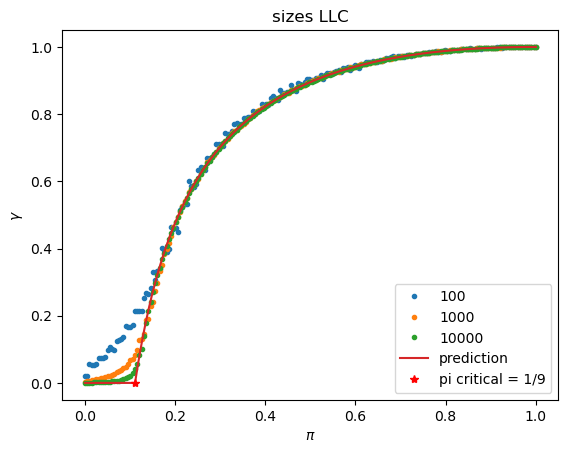

In [35]:
Pi = np.linspace(0,1,200,endpoint=True)
plt.plot(Pi,ms_cc_100[:,0]/100,".",label="100")
plt.plot(Pi,ms_cc_1000[:,0]/1000,".",label="1000")
plt.plot(Pi,ms_cc_10000[:,0]/10000,".",label="10000")
plt.plot(Pix,gammas,label="prediction")
plt.plot([pi_c],[0], "r*", label="pi critical = 1/9")
plt.title("sizes LLC")
plt.xlabel(r"$\pi$")
plt.ylabel(r"$\gamma $")
plt.savefig("LLC.png")
plt.legend()

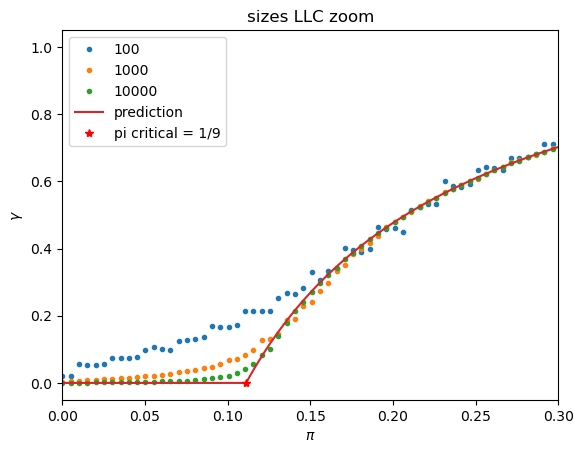

In [54]:
Pi = np.linspace(0,1,200,endpoint=True)
plt.plot(Pi,ms_cc_100[:,0]/100,".",label="100")
plt.plot(Pi,ms_cc_1000[:,0]/1000,".",label="1000")
plt.plot(Pi,ms_cc_10000[:,0]/10000,".",label="10000")
# max2 = np.argmax(ms_cc_100[:,1])
# max3 = np.argmax(ms_cc_1000[:,1])
# max4 = np.argmax(ms_cc_10000[:,1])
# plt.axvline(x=Pi[max2],color="b", linestyle='-')
# plt.axvline(x=Pi[max3],color="y", linestyle='-')
# plt.axvline(x=Pi[max4],color="g", linestyle='-')
plt.plot(Pix,gammas,label="prediction")
plt.plot([pi_c],[0], "r*", label="pi critical = 1/9")
plt.legend()
plt.title("sizes LLC zoom")
plt.xlabel(r"$\pi$")
plt.ylabel(r"$\gamma $")

plt.xlim(0,0.3)
plt.savefig("LLC_zoom.png")

(0.0, 0.3)

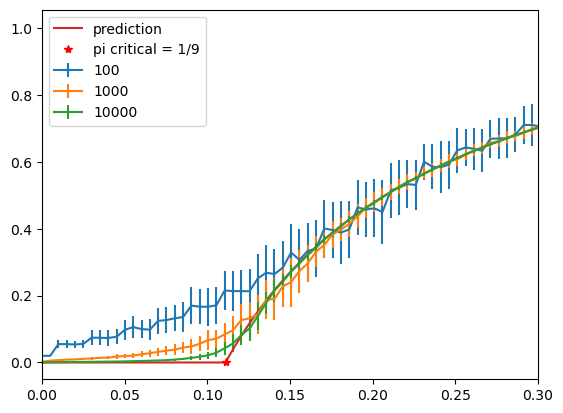

In [86]:
Pi = np.linspace(0,1,200,endpoint=True)
plt.errorbar(Pi,ms_cc_100[:,0]/100,yerr=ms_cc_100[:,1]/100,label="100")
plt.errorbar(Pi,ms_cc_1000[:,0]/1000,yerr=ms_cc_1000[:,1]/1000,label="1000")
plt.errorbar(Pi,ms_cc_10000[:,0]/10000,yerr=ms_cc_10000[:,1]/10000,label="10000")
plt.plot(Pix,gammas,label="prediction")
plt.plot([pi_c],[0], "r*", label="pi critical = 1/9")
plt.legend()
plt.xlim(0,0.3)

Here I plot the standard deviations over the sizes of the Largest connected components measured, It seems that there is a peak in it, as we expect for the susceptibility in a second order phase transition. Without being able to explain it theoretical I imagine that this divergence of the susceptibility of the size of the LLC to $\pi$ happen at the transition value, that since we sample a slightly **biased** version of the configurational model it shifted at finite N, in particular, on the right of the actual transition value.
- maximal value of standard deviation for different N seems to tend from the right to the actual value of $\frac{1}{9}$
- Normalized value of the maximum standard deviation decreases with N (Self-averaging(?))

0.1306532663316583 0.15075376884422112 0.18090452261306533


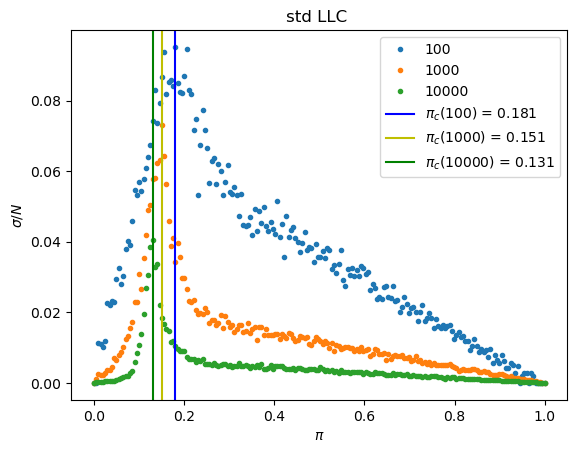

In [58]:
Pi = np.linspace(0,1,200,endpoint=True)
max2 = np.argmax(ms_cc_100[:,1])
max3 = np.argmax(ms_cc_1000[:,1])
max4 = np.argmax(ms_cc_10000[:,1])
plt.plot(Pi,ms_cc_100[:,1]/100,".",label="100")
plt.plot(Pi,ms_cc_1000[:,1]/1000,".",label="1000")
plt.plot(Pi,ms_cc_10000[:,1]/10000,".",label="10000")
# plt.plot(Pix,gammas,label="prediction")
max2 = np.argmax(ms_cc_100[:,1])
max3 = np.argmax(ms_cc_1000[:,1])
max4 = np.argmax(ms_cc_10000[:,1])
plt.axvline(x=Pi[max2],color="b", linestyle='-',label=fr"$\pi_c(100)$ = {Pi[max2]:.3f}")
plt.axvline(x=Pi[max3],color="y", linestyle='-',label=fr"$\pi_c(1000)$ = {Pi[max3]:.3f}")
plt.axvline(x=Pi[max4],color="g", linestyle='-',label=fr"$\pi_c(10000)$ = {Pi[max4]:.3f}")
# plt.plot([pi_c,Pi[max4], Pi[max3], Pi[max2]],[0,0,0,0], "r*", label="pi critical estimates")
plt.legend()
plt.title("std LLC ")
plt.xlabel(r"$\pi$")
plt.ylabel(r"$\sigma / N $")
plt.savefig("LLC_std.png")
print(Pi[max4], Pi[max3], Pi[max2])

### 3-core sizes

In [11]:
cores100_loaded = np.load("sizecores100.npy")
cores1000_loaded = np.load("sizecores1000.npy")
cores10000_loaded = np.load("sizecores10000.npy")

In [12]:
ms_3c_100 = mean_size(cores100_loaded)
ms_3c_1000 = mean_size(cores1000_loaded)
ms_3c_10000 = mean_size(cores10000_loaded)

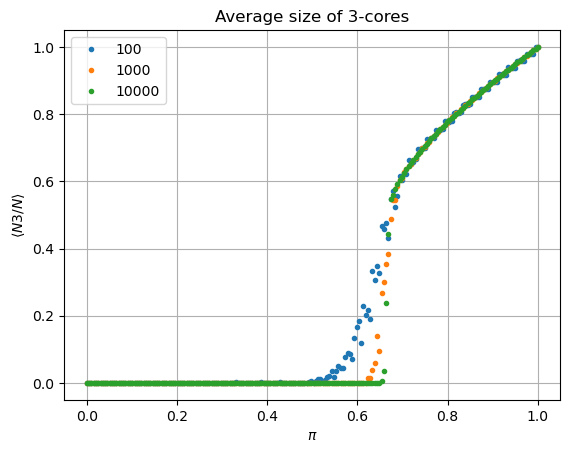

In [61]:
Pi = np.linspace(0,1,200,endpoint=True)
plt.plot(Pi,ms_3c_100[:,0]/100,".",label="100")
plt.plot(Pi,ms_3c_1000[:,0]/1000,".",label="1000")
plt.plot(Pi,ms_3c_10000[:,0]/10000,".",label="10000")
# plt.plot(Pix,gammas,label="prediction")
# plt.plot([pi_c],[0], "r*", label="pi critical = 1/9")
plt.title("Average size of 3-cores")
plt.xlabel(r"$\pi$")
plt.ylabel(r"$\langle N3/N \rangle$")
plt.grid(True)
plt.legend()
plt.savefig("3_cores_exp.png")

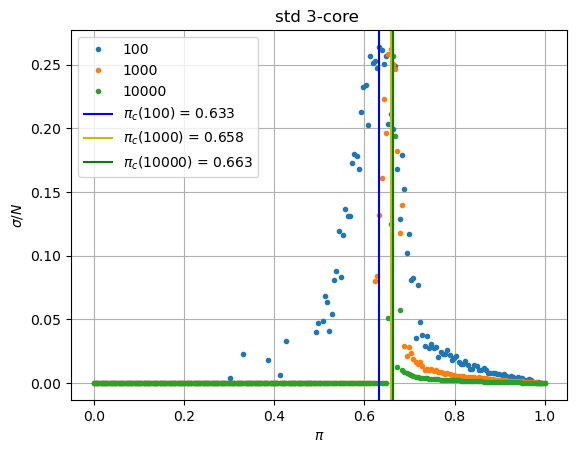

In [60]:
Pi = np.linspace(0,1,200,endpoint=True)
plt.plot(Pi,ms_3c_100[:,1]/100,".",label="100")
plt.plot(Pi,ms_3c_1000[:,1]/1000,".",label="1000")
plt.plot(Pi,ms_3c_10000[:,1]/10000,".",label="10000")
max2 = np.argmax(ms_3c_100[:,1])
max3 = np.argmax(ms_3c_1000[:,1])
max4 = np.argmax(ms_3c_10000[:,1])
plt.axvline(x=Pi[max2],color="b", linestyle='-',label=fr"$\pi_c(100)$ = {Pi[max2]:.3f}")
plt.axvline(x=Pi[max3],color="y", linestyle='-',label=fr"$\pi_c(1000)$ = {Pi[max3]:.3f}")
plt.axvline(x=Pi[max4],color="g", linestyle='-',label=fr"$\pi_c(10000)$ = {Pi[max4]:.3f}")
# plt.plot(Pix,gammas,label="prediction")
plt.title("std 3-core ")
plt.xlabel(r"$\pi$")
plt.ylabel(r"$\sigma / N $")
plt.grid(True)
# plt.plot([pi_c],[0], "r*", label="pi critical = 1/9")
plt.legend()
plt.savefig("3core_std.png")

## Theoretical size of the q-core

We need to solve this:
$$ \partial_t [(1-t)p_d(t)] = - \frac{\chi_d p_d(t)}{\overline{\chi_d}} + \frac{\overline{d\chi_d}}{c(t)\overline{\chi_d}}\left[ (d+1)p_{d+1} - d p_d  \right] := RHS[p_d(t)]$$

that can be rewritten as:
$$ \partial_t p_d(t) = \frac{p_d(t)+RHS[p_d(t)]}{1-t} := f[p_d(t),t]$$
where f is what is implemented below to to do numerical integration

In [43]:
@njit
def f(t, p):
    # this function compute the parts above
    chi = np.array([1, 1, 1, 0, 0], dtype=np.float64)
    a1 = p / (1.0 - t) 
    
    d = np.array([0, 1, 2, 3, 4], dtype=np.float64)
    c = np.dot(d, p)
    
    chi_exp = np.sum(np.multiply(chi, p))
    dchi_exp = np.sum(np.multiply(np.multiply(p, chi), d))
    
    b1 = -np.multiply(p, chi) / chi_exp
    b2 = -dchi_exp / chi_exp * np.multiply(d, p) / c if c != 0 else np.zeros_like(p)
    
    dp1 = np.array([1, 2, 3, 4, 5], dtype=np.float64)
    pp1 = np.append(p[1:], [0])
    b3 = dchi_exp / chi_exp * np.multiply(dp1, pp1) / c if c != 0 else np.zeros_like(p)
    
    a2 = 1.0 / (1.0 - t) * (b1 + b2 + b3)
    return a1 + a2


# @njit(int64,int64(int64,int64,int64))
@njit
def rk4_step(x0,y0,h):
    # runge kutta method
    k1 = h * (f(x0, y0))
    k2 = h * (f((x0+h/2), (y0+k1/2)))
    k3 = h * (f((x0+h/2), (y0+k2/2)))
    k4 = h * (f((x0+h), (y0+k3)))
    k = (k1+2*k2+2*k3+k4)/6
    y = y0 + k
    return x0+h,y

@njit
def normalize(p):
    return p/np.sum(p)

In [45]:
pi = 0.4
h = 0.001
@njit
def integrate(pi,h):

    # When integrating I start from the p_d that we expect given pi
    p = np.array([0,1-pi,0,0,pi])
    t = 0

    # run until either no more nodes of order < 3 or t = 1
    while (p[0] > 0 or p[1] > 0 or p[2] > 0) and t<1:

        # RK4 step
        t, p = rk4_step(t,p,h)

        # if a value becomes negative I fix it to 0
        p = np.maximum(p,0)

        # normalize p_d(t)
        p = normalize(p)

        # if p_3 and p_4 go to zero I am sure to not have a 3-core
        if p[3]==0 and p[4] == 0:
            return 0

    return 1-t

In [40]:
# I integrate only over 0.6 since from a previous run I saw that all resuts were zero below
# and it is computationally expensive
Piq = np.linspace(0.6,1,200) 
h = 0.0000005 # step molto piccolo sembra importante
# integrate in paralell
sizeq = Parallel(n_jobs=-1,verbose=10)(delayed(integrate)(pi,h) for pi in Piq)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

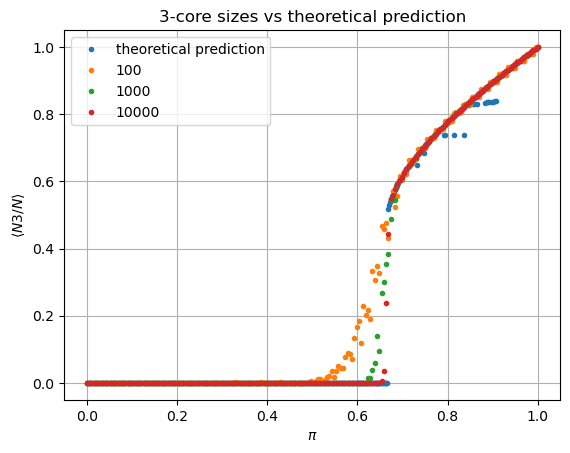

In [59]:
Pis0 = np.linspace(0,0.6,200,endpoint=False)
Pitot = np.concatenate((Pis0,Piq))
sizeq_tot = np.concatenate((np.zeros(200),sizeq))
plt.plot(Pitot,sizeq_tot,'.',label="theoretical prediction")
Pi = np.linspace(0,1,200,endpoint=True)
plt.plot(Pi,ms_3c_100[:,0]/100,".",label="100")
plt.plot(Pi,ms_3c_1000[:,0]/1000,".",label="1000")
plt.plot(Pi,ms_3c_10000[:,0]/10000,".",label="10000")
# plt.plot(Pix,gammas,label="prediction")
# plt.plot([pi_c],[0], "r*", label="pi critical = 1/9")
plt.legend()
plt.title("3-core sizes vs theoretical prediction")
plt.xlabel(r"$\pi$")
plt.ylabel(r"$\langle N3/N \rangle$")
plt.grid(True)
plt.savefig("3_cores_exp_th.png")


In [62]:
ms_3c_10000[:,0]/10000

array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.   

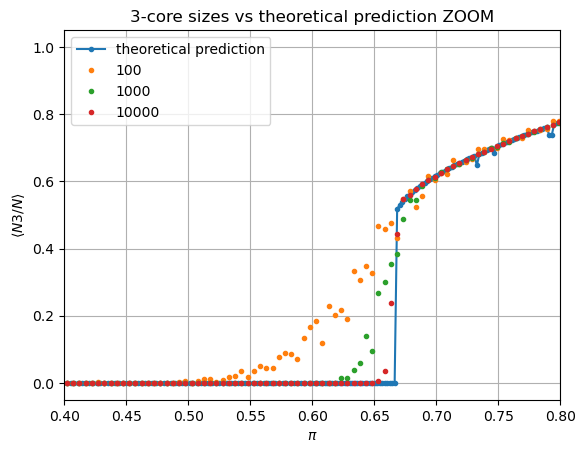

In [58]:
Pis0 = np.linspace(0,0.6,200,endpoint=False)
Pitot = np.concatenate((Pis0,Piq))
sizeq_tot = np.concatenate((np.zeros(200),sizeq))
plt.plot(Pitot,sizeq_tot,'.-',label="theoretical prediction")
Pi = np.linspace(0,1,200,endpoint=True)
plt.plot(Pi,ms_3c_100[:,0]/100,".",label="100")
plt.plot(Pi,ms_3c_1000[:,0]/1000,".",label="1000")
plt.plot(Pi,ms_3c_10000[:,0]/10000,".",label="10000")
# plt.plot(Pix,gammas,label="prediction")
# plt.plot([pi_c],[0], "r*", label="pi critical = 1/9")
plt.xlim(0.4,0.8)
plt.title("3-core sizes vs theoretical prediction ZOOM")
plt.xlabel(r"$\pi$")
plt.ylabel(r"$\langle N3/N \rangle$")
plt.grid(True)
plt.legend()
plt.savefig("3_cores_exp_th_zoom.png")

### Find a better estimation for the transition value

In [131]:
Piq_fin = np.linspace(0.65,0.7,1000)
h = 0.000001 # step molto piccolo sembra importante
sizeq_fin = Parallel(n_jobs=-1,verbose=10)(delayed(integrate)(pi,h) for pi in Piq_fin)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

(0.665, 0.668)

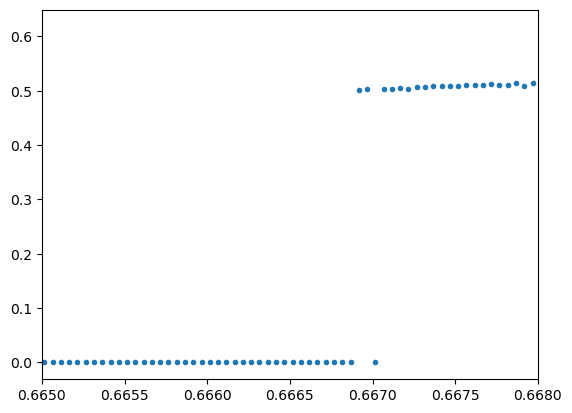

In [136]:
plt.plot(Piq_fin,sizeq_fin,'.')
plt.xlim(0.665,0.668)

it takes two minutes to run the next code

In [44]:
Piq_fin2 = np.linspace(0.6665,0.6672,50)
h = 2e-7 
sizeq_fin = Parallel(n_jobs=-1,verbose=10)(delayed(integrate)(pi,h) for pi in Piq_fin2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  1.7min remaining:   22.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  1.9min remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


In [53]:
Piq_fin2 = np.array(Piq_fin2)
sizeq_fin = np.array(sizeq_fin)
np.save("size_q_fin", sizeq_fin)

0.49684779998759143


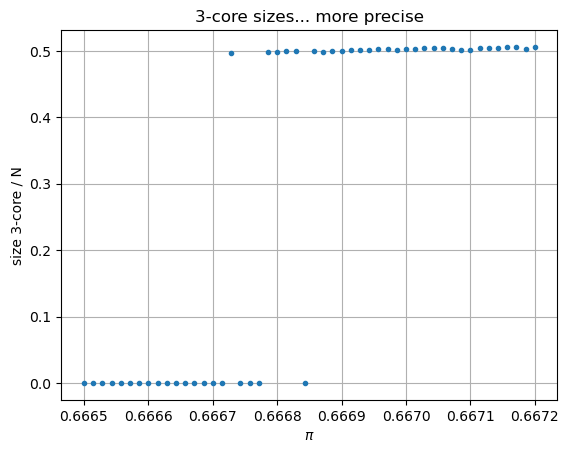

In [57]:
plt.plot(Piq_fin2,sizeq_fin,'.')
size_c = np.min(sizeq_fin[sizeq_fin>0])
print(size_c)
plt.title("3-core sizes... more precise")
plt.xlabel(r"$\pi$")
plt.ylabel("size 3-core / N")
plt.grid(True)
plt.savefig("3_core_precise.png")

# Problem 4: The ferromagnetic ising model

## MCMC

In [66]:
@njit
def init_state(N):
    # return a random initial state
    return np.random.choice(np.array([-1,1]),size=(N))

@njit
def energy(state,al):
    # energy of a configuration
    N = state.shape[0]
    energy = 0

    for i in range(N):
        nn = 0
        neig = al[i,:]
        nn = np.sum(state[neig[neig>=0]])
        energy -= state[i] * nn
    
    return energy/2

@njit
def wolff(state, T, al):
    beta = 1./T
    N = state.shape[0]

    # probability to add a spin in a cluster to flip
    p_add = 1. - np.exp(-2*beta)

    i = np.random.randint(N)
    # value of the spin from which we start the cluster
    spin = state[i]

    # array t keep track of elements in the cluster and to possibly add (stack)
    cluster = np.zeros(N,dtype='bool')
    stack = np.zeros(N,dtype='bool')

    stack[i], cluster[i] = True, True

    # until stack is empty
    while not (stack == False).all():

        # take the first element in the stack
        i = np.argmax(stack)

        # remove from the stack
        stack[i] = False

        # look in the neighboors and in case add
        neig = al[i,:]
        neig = neig[neig>=0]
        for j in neig:
            if cluster[j] == False and state[j] == spin:
                if np.random.rand() < p_add:
                    stack[j] = True
                    cluster[j] = True
    
    # flip the cluster
    state[np.where(cluster)] *= -1

    return state


# glauber dynamics not used
@njit
def glauber(state,T,al):
    beta = 1./T
    N =state.shape[0]
    i = np.random.randint(N)
    neig = al[i,:]
    nn = np.sum(state[neig[neig>=0]])
    delta = 2 * state[i] * nn
    if delta < 0 or np.random.random() < np.exp(- beta * delta):
        state[i] *= -1
    return state

In [65]:
def MCMC(N,pi,T,n=500,seed=0,ret_state=False):

    # sample the random graph
    np.random.seed(seed)
    el = sample_mask_list(N,pi)
    al = el_al(el,N,how="np")

    # first run to compute correlation time
    tstep=10000
    M = np.zeros(tstep+1)
    E = np.zeros(tstep+1)
    state = init_state(N)

    # in case I want to return the states
    if ret_state:
        states = np.zeros((n,N))

    for t in range(tstep+1):
        M[t] = np.sum(state)
        E[t] = energy(state,al)
        state = wolff(state,T,al)

    # compute autocorrelation time
    autocfE = acf(E,nlags=10000)
    tau_eq = np.where(autocfE<0)[0][0]
    autocfM = acf(M[tau_eq:],nlags=10000)
    tau_corr = np.where(autocfM<0)[0][0]
    
    # I continue the simulation from last state, already thermalized
    # save the n(=500) uncorrelated samples of M
    M = np.zeros(n)
    for i in range(n):
        for _ in range(tau_corr):
            state = wolff(state,T,al)
        if ret_state:
            states[i,:] = state
        M[i] = np.sum(state)

    if ret_state:
        return states

    return M/N
    

In [105]:
m_test = MCMC(1000,0.5,1.)

0.7717719999999999

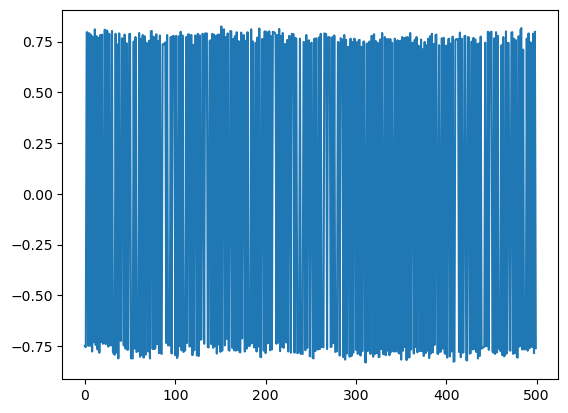

In [106]:
plt.plot(m_test)
np.mean(np.abs(m_test))

In [138]:
N = 1000
el = sample_mask_list(N,0.7)
al = el_al(el,N,how="np")
al

array([[982,  -1,  -1,  -1],
       [595,  -1,  -1,  -1],
       [318,  -1,  -1,  -1],
       ...,
       [969, 945, 542, 313],
       [354, 772, 191, 561],
       [932, 587, 929, 551]])

In [141]:
tstep = 10000
N = 1000
T = 4
state = init_state(N)
M = np.zeros(tstep+1)
E = np.zeros(tstep+1)
for t in range(tstep+1):
    M[t] = np.sum(state)
    E[t] = energy(state,al)
    state = wolff(state,T,al)

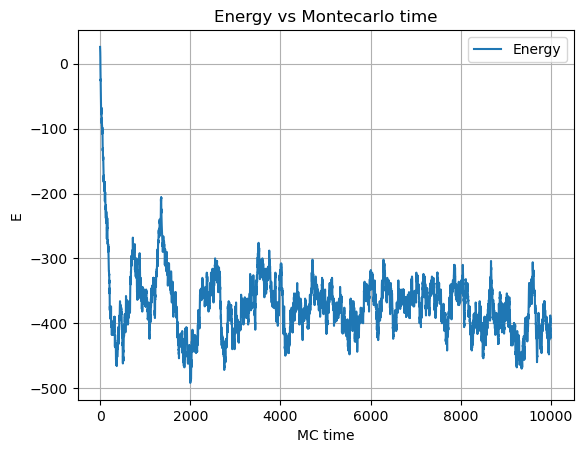

In [142]:
plt.plot(E,label="Energy")
plt.title("Energy vs Montecarlo time")
plt.xlabel("MC time")
plt.ylabel("E")
plt.legend()
plt.grid(True)
plt.savefig("thermalization.png")


Autocorrelation time is 424


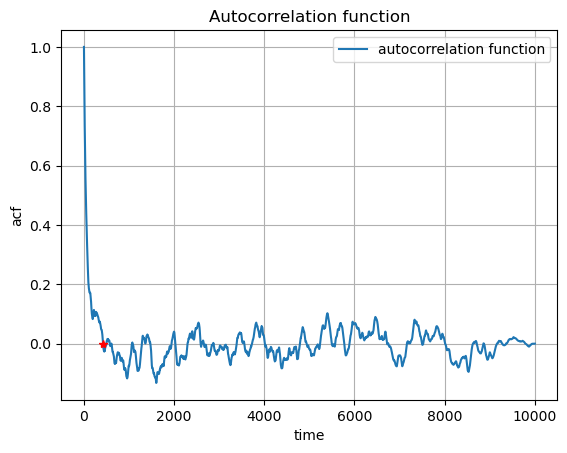

In [145]:
autocf = acf(M,nlags=50000)
plt.plot(autocf,label="autocorrelation function")
plt.xlabel("time")
plt.ylabel("acf")
plt.title("Autocorrelation function")
plt.legend()
plt.grid(True)


j = 0
for i, a in enumerate(autocf):
    if a<1/np.e:
        j=i
        break
k = np.where(autocf<1/np.e)[0][0]
k0 = np.where(autocf<0)[0][0]
print(f"Autocorrelation time is {k0}")
plt.plot([k0],[0],"r*")

plt.savefig("acf.png")

(96, 96, 408)

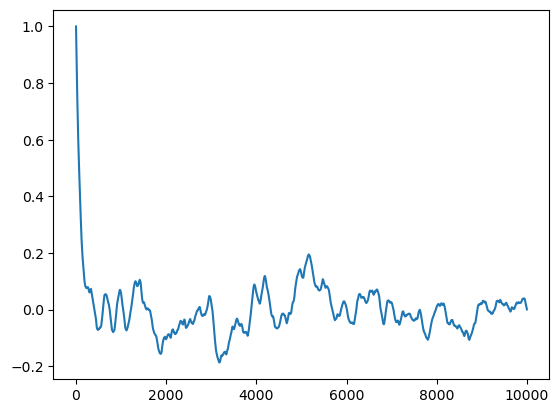

In [144]:
autocf = acf(E,nlags=50000)
plt.plot(autocf)
j = 0
for i, a in enumerate(autocf):
    if a<1/np.e:
        j=i
        break
k = np.where(autocf<1/np.e)[0][0]
k0 = np.where(autocf<0)[0][0]
k,j,k0

(78, 78, 384)

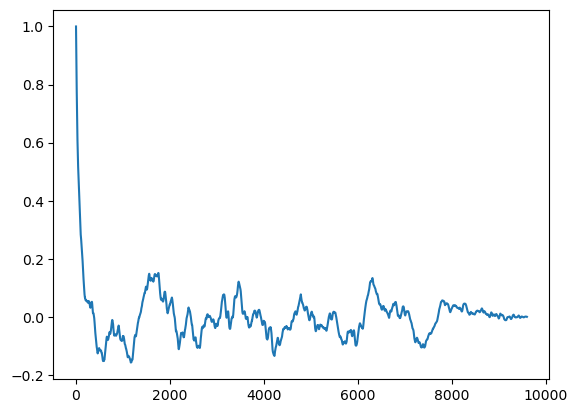

In [145]:
autocf = acf(M[k0:],nlags=50000)
plt.plot(autocf)
j = 0
for i, a in enumerate(autocf):
    if a<1/np.e:
        j=i
        break
k = np.where(autocf<1/np.e)[0][0]
k0 = np.where(autocf<0)[0][0]
k,j,k0

0.001513875


32

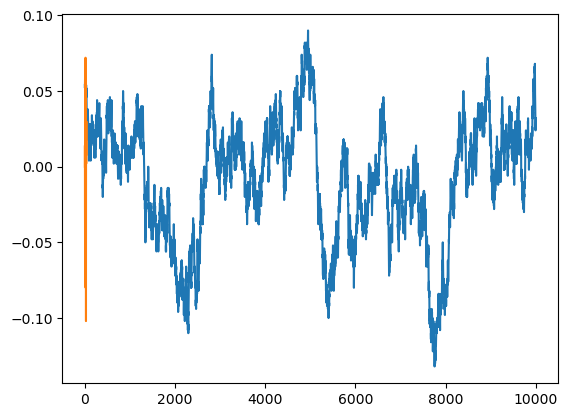

In [134]:
plt.plot(M/1000)
ms = M[k0::k]
plt.plot(ms/1000)
print(np.mean(np.array(ms/1000)**2))
len(ms)

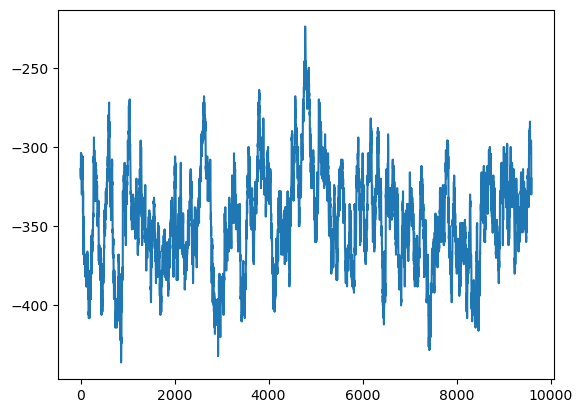

In [142]:
plt.plot(E[k0:])


(167, 167, 561)

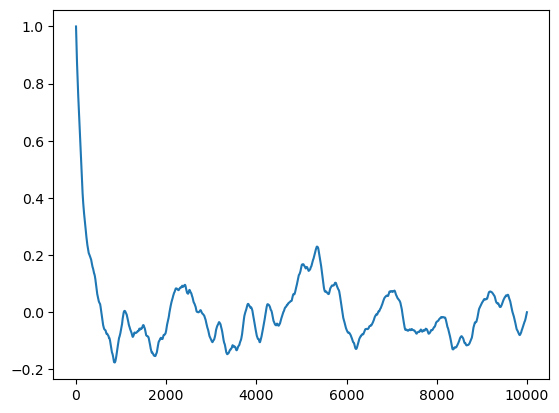

In [137]:
autocf = acf(E,nlags=50000)
plt.plot(autocf)
j = 0
for i, a in enumerate(autocf):
    if a<1/np.e:
        j=i
        break
k = np.where(autocf<1/np.e)[0][0]
k0 = np.where(autocf<0)[0][0]
k,j,k0

### Experiment: large

In [95]:
# night
Ts = np.linspace(0.5,3.5,100)
Pis_1 = np.array([0.05, 0.1, 0.2,0.3, 0.4, 0.5,0.6, 0.7,0.8, 0.9])
n = 5000
N = 1000
mss = np.zeros((Ts.shape[0],Pis_1.shape[0],n))
tot = Ts.shape[0]*Pis_1.shape[0]
seeds = np.random.randint(1e8,size=tot)
for j, T in enumerate(Ts):
    mT = Parallel(n_jobs=-1,verbose=5)(delayed(MCMC)(N,pi,T,seed=seeds[i+(j*5)],n=n) for i, pi in enumerate(Pis_1))
    for i, elm in enumerate(mT):
        mss[j,i,:] = elm
    j += 1



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   11.9s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   15.4s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    8.7s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   11.4s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   11.4s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

In [96]:
np.save("mss_N1e4_n1me3_large_big",mss)

In [97]:
# mss = np.load("mss_N1e4_n1e3_large.npy")
mss_fit = np.load("ss_N1e4_n1me3_large_fit.npy")
mss_big = np.load("mss_N1e4_n1me3_large_big.npy")

In [88]:
mss_fit.shape
# 5 Temperatures, 10 values of pi, 10000 samples
mss[-1,-1,:].max()

0.23

In [ ]:
# 100 histograms
Ts = np.linspace(0.5,3.5,100)
Pis_1 = np.array([0.05, 0.1, 0.2,0.3, 0.4, 0.5,0.6, 0.7,0.8, 0.9])
for i, T in enumerate(Ts):
    for j, pi in enumerate(Pis_1):
        plt.hist(mss_big[i,j,:],density=True,label=fr"T={T:.2f}, $\pi$={pi:.2f}")
    plt.legend()
    plt.show()


In [74]:
mss.shape
# 5 Temperatures, 10 values of pi, 10000 samples
mss[-1,-1,:].max()

0.077

In [100]:
m_chi = np.zeros((Ts.shape[0],Pis_1.shape[0],2))
for j, T in enumerate(Ts):
    for i, elm in enumerate(Pis_1):
        m_chi[j,i,0] = np.mean(np.abs(mss_big[j,i,:]))
        m_chi[j,i,1] = 1/T*(np.mean(mss_big[j,i,:]**2)-m_chi[j,i,0]**2)

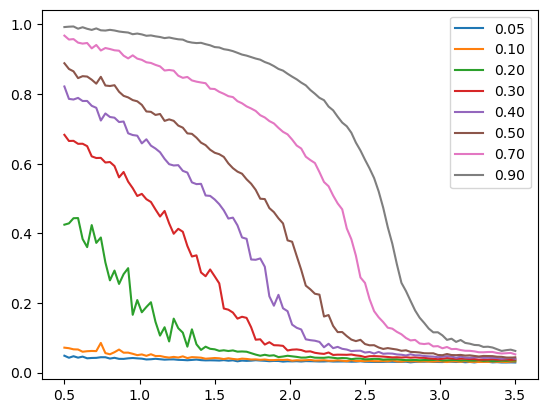

In [104]:
for i, elm in enumerate(Pis_1):
    plt.plot(Ts, m_chi[:,i,0],label=f"{elm:.2f}")
plt.legend()

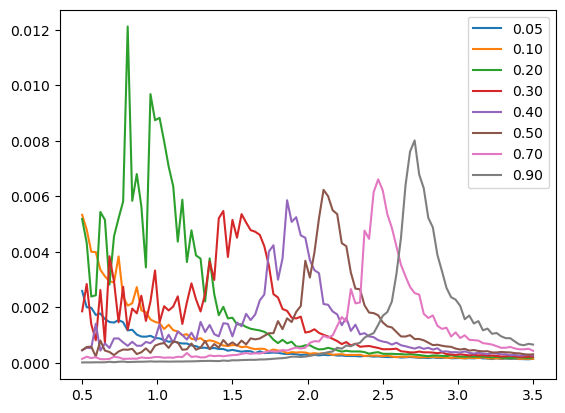

In [103]:
for i, elm in enumerate(Pis_1):
    plt.plot(Ts, m_chi[:,i,1],label=f"{elm:.2f}")
plt.legend()

## Belief propagation

In [155]:
@njit(float64(float64[:,:],float64,int64,int64))
def update(h,T,k,i):
    beta = 1./T
    return np.log((np.cosh(beta*(h[k,i]+1)))/np.cosh(beta*(h[k,i]-1)))

@njit
def belief_propagation(al,T,h_c0,max_iter,tol=1e-3):
    N = al.shape[0]
    beta = 1./T
    h_c = h_c0
    dist = 1
    count = 0
    while dist > tol and count < max_iter:
        count +=1
        h_c_new = np.zeros_like(h_c0)
        for i in range(N):
            for j in range(N):
                h_prov = 0
                neigbar = al[i,:]
                neigbar = neigbar[neigbar>=0]
                neigbar = neigbar[neigbar!=j]
                for k in neigbar:
                    h_prov += update(h_c,T,k,i)
                i = int(i)
                h_c_new[i,j] = 1/(2*beta) * h_prov
        dist = np.sqrt(np.sum((h_c_new-h_c)**2))
        h_c = h_c_new

    h = np.zeros((N))
    for i in range(N):
        hi = 0
        neig = al[i,:]
        neig = neig[neig>=0]
        for k in neig:
            hi += update(h_c,beta,k,i)
        h[i] = 1/(2*beta) * hi

    return h
        

In [159]:
@njit
def dist(h,T,s):
    beta = 1./T
    return np.exp(beta*s*h)/(2*np.cosh(beta*h))

@njit
def h_to_m(h,T):
    beta = 1./T
    m = np.zeros_like(h)
    for i, hi in enumerate(h):
        m[i] = dist(hi,beta,1)-dist(hi,beta,-1)
    return m 


In [182]:
def bp(N,pi,T,max_iter,tol=1e-3,seed=0):
    np.random.seed(seed)
    el = sample_mask_list(N,pi)
    al = el_al(el,N,how="np")
    h_c0 = np.random.standard_normal((N,N))
    h = belief_propagation(al,1,h_c0,max_iter,tol)
    m = h_to_m(h,T)
    return m

In [196]:
Ts = np.linspace(0.5,3.5,100)
Pis_1 = np.array([0.05, 0.1, 0.2,0.3, 0.4, 0.5,0.6, 0.7,0.8, 0.9])
# Ts = np.array([1.5,2.5,3.5])
# Pis_1 = np.array([0.1,0.5,0.8])
N = 100
max_iter = 1e5
tol = 1e-6
lim = Pis_1.shape[0]
tot = Ts.shape[0]*Pis_1.shape[0]
seeds = np.random.randint(1e8,size=tot)
ms_bp = np.zeros((Ts.shape[0],Pis_1.shape[0],N))
for j, T in enumerate(Ts):
    mT = Parallel(n_jobs=-1,verbose=5)(delayed(bp)(N,pi,T,max_iter,tol=tol,seed=seeds[i+(j*lim)]) for i, pi in enumerate(Pis_1))
    for i, elm in enumerate(mT):
        ms_bp[j,i,:] = elm
    

np.save("ms_bp",ms_bp)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished


In [197]:
ms_bp

array([[0.        , 0.84077414, 0.9796476 ],
       [0.        , 0.8692779 , 0.97728804],
       [0.        , 0.84899318, 0.99956927]])

In [194]:
import sys
size = sys.getsizeof(hc_pd)
size/(2**30)*1000

6.70565664768219

In [187]:
hc_pd.shape, h_pd.shape

((3, 3, 100000), (3, 3, 100000))

In [183]:
bp(N,pi,T,max_iter,tol=tol)

array([-0.75424383, -0.71107676, -0.8833979 , -0.90175156, -0.88591193,
        0.        , -0.88361169, -0.89823325,  0.        , -0.90090434,
       -0.9017689 , -0.87672024, -0.88589394, -0.86598464, -0.89889718,
        0.        , -0.90163106, -0.71753179, -0.90213571, -0.90216075,
        0.        , -0.90180164, -0.90249399, -0.90180875, -0.86195408,
        0.        , -0.90243669, -0.89939489, -0.75600608, -0.9018332 ,
       -0.88536726, -0.89948221, -0.89937587, -0.89977255, -0.90146983,
       -0.88544723, -0.88079071,  0.        , -0.90174276,  0.        ,
       -0.88537542, -0.90253956,  0.        , -0.89871422,  0.        ,
       -0.9021067 , -0.89934675,  0.        , -0.88299677, -0.90184134,
       -0.7092126 , -0.90175526, -0.75524767, -0.86615005, -0.90178224,
       -0.90123312, -0.90205843, -0.89855622, -0.88587047, -0.90141683,
       -0.90177218, -0.88289572, -0.60894276, -0.90133453,  0.        ,
        0.        , -0.89845292, -0.87952915,  0.        ,  0.  

## Population dynamics

cavity ---> q_{d+1}

normal ---> p_{d}

In [72]:
@njit(float64(int64,float64))
def q_d(d,pi):
    if d == 1: return (1-pi)/(1+3*pi)
    elif d == 4: return (4*pi)/(1+3*pi)
    else: return 0.

def p_d(d,pi):
    if d ==1: return 1-pi
    elif d == 4: return pi
    else: return 0

In [179]:
@njit(float64(float64[:],float64,int64))
def update_pop(h,T,k):
    beta = 1./T
    return np.log((np.cosh(beta*(h[k]+1)))/np.cosh(beta*(h[k]-1)))

@njit(float64(int64,float64))
def q_d(d,pi):
    if d == 1: return (1-pi)/(1+3*pi)
    elif d == 4: return (4*pi)/(1+3*pi)
    else: return 0.

@njit(float64(int64,float64))
def p_d(d,pi):
    if d ==1: return 1-pi
    elif d == 4: return pi
    else: return 0

@njit(float64(float64[:],int64))
def moment(arr,k):
    return np.mean(arr**k)

@njit(float64[:](float64[:],int64,int64,float64,float64))
def pop_dyn(hc_start,T,Tstop,tol,pi):
    M = hc_start.shape[0]
    for t in range(Tstop):
        hc = hc_start.copy()
        for m in range(M):
            if np.random.rand() < q_d(4,pi):
                k = 3
                hc_prov = 0
                for _ in range(k):
                    l = np.random.randint(M)
                    hc_prov += update_pop(hc_start,T,l) 
                hc[m] = T/2 * hc_prov   
        # if np.abs(hc.mean() -hc_start.mean()) < tol and np.abs(hc.var() -hc_start.var())<tol:
        #     print(t/Tstop)
        #     break
        # else:
        #     hc_start = hc
        # hc_start = hc
        if np.abs(hc.mean() -hc_start.mean()) < tol and np.abs(hc.var() -hc_start.var())<tol and np.abs(moment(hc,3)-moment(hc_start,3)) < tol:
            print(f"{t}/{Tstop}")
            break
        else:
            hc_start = hc
        
    return hc

@njit(float64[:](float64[:],int64,int64,float64,float64))
def pop_dyn2(hc_start,T,Tstop,tol,pi):
    M = hc_start.shape[0]
    for t in range(Tstop):
        hc = hc_start.copy()
        for m in range(M):
            if np.random.rand() < q_d(4,pi):
                k = 3
            else:
                k = 1
            hc_prov = 0
            for _ in range(k):
                l = np.random.randint(M)
                hc_prov += update_pop(hc_start,T,l) 
            hc[m] = T/2 * hc_prov   
        # if np.abs(hc.mean() -hc_start.mean()) < tol and np.abs(hc.var() -hc_start.var())<tol:
        #     print(t/Tstop)
        #     break
        # else:
        #     hc_start = hc
        # hc_start = hc
        if np.abs(hc.mean() -hc_start.mean()) < tol and np.abs(hc.var() -hc_start.var())<tol and np.abs(moment(hc,3)-moment(hc_start,3)) < tol:
            print(f"{t}/{Tstop}")
            break
        else:
            hc_start = hc
        
    return hc


@njit(float64[:](float64[:],float64[:],int64,int64,float64,float64))
def pop_dyn_h(hc,h,T,Tstop,tol,pi):
    M = hc.shape[0]
    h = h.copy()
    for t in range(Tstop):
        h_new = h.copy()
        for m in range(M):
            if np.random.rand() < p_d(4,pi):
                k = 4
            else:
                k = 1
            h_prov = 0
            for _ in range(k):
                l = np.random.randint(M)
                h_prov += update_pop(hc,T,l) 
            h_new[m] = T/2 * h_prov   
        # if np.abs(hc.mean() -hc_start.mean()) < tol and np.abs(hc.var() -hc_start.var())<tol:
        #     print(t/Tstop)
        #     break
        # else:
        #     hc_start = hc
        # hc_start = hc
        if np.abs(h.mean() -h_new.mean()) < tol and np.abs(h.var() -h_new.var())<tol:
            print(f"{t}/{Tstop}")
            break
        else:
            h_new = h
        
    return hc

@njit
def pd(M,pi,T,Tstop,tol):
    hc_start = np.random.normal(0,10 ,size=M)
    hc = pop_dyn(hc_start,T,Tstop,tol,pi)
    h = np.random.normal(0,10 ,size=M)
    h = pop_dyn_h(hc,h,T,Tstop,tol,pi)
    return hc, h

In [180]:
M = int(1e5)
pi = 0.5
T = 1.5
Tstop = 1000
tol = 1e-5
hc, h = pd(M,pi,T,Tstop,tol)

27/1000


In [185]:
Ts = np.linspace(0.5,3.5,100)
Pis_1 = np.array([0.05, 0.1, 0.2,0.3, 0.4, 0.5,0.6, 0.7,0.8, 0.9])
# Ts = np.array([1.5,2.5,3.5])
# Pis_1 = np.array([0.1,0.5,0.8])
lim = Pis_1.shape[0]
M = int(1e5)
Tstop = 1000
tol = 1e-5
tot = Ts.shape[0]*Pis_1.shape[0]
seeds = np.random.randint(1e8,size=tot)
hc_pd = np.zeros((Ts.shape[0],Pis_1.shape[0],M))
h_pd = np.zeros((Ts.shape[0],Pis_1.shape[0],M))
for j, T in enumerate(Ts):
    mT = Parallel(n_jobs=-1,verbose=5)(delayed(bp)(N,pi,T,max_iter,tol=tol,seed=seeds[i+(j*lim)]) for i, pi in enumerate(Pis_1))
    for i, elm in enumerate(mT):
        hc_pd[j,i,:] = elm[0]
        h_pd[j,i,:] = elm[1]

np.save("hc_pd",hc_pd)
np.save("h_pd",h_pd)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.5s finished


In [199]:
import sys
size = sys.getsizeof(hc_pd)
size/(2**30)*1000/9

0.7450729608535767

23/1000


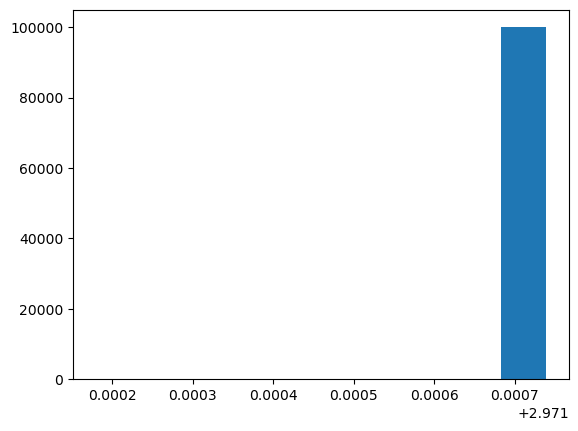

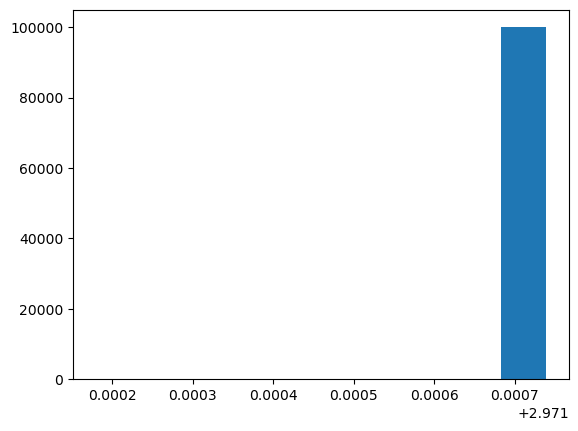

In [178]:
M = int(1e5)
hc_start = np.random.normal(0,10 ,size=M)
T = 1.5
Tstop = 1000
tol = 1e-5
pi = 0.7
hc = pop_dyn(hc_start,T,Tstop,tol,pi)
# for pi in np.linspace(0,1,100):
#     pop_dyn(hc_start,T,Tstop,tol,pi)
plt.hist(hc)
plt.show()
h = np.random.normal(0,10 ,size=M)
h = pop_dyn_h(hc,h,T,Tstop,tol,pi)
plt.hist(h)
plt.show()
m = h_to_m(h,T)

NameError: name 'm' is not defined

# Problem 5: Inverse Ising model

In [200]:
def MCMC_al(N,al,T,n=500,seed=0,ret_state=False):

    # sample the random graph
    np.random.seed(seed)

    # first run to compute correlation time
    tstep=10000
    M = np.zeros(tstep+1)
    E = np.zeros(tstep+1)
    state = init_state(N)

    # in case I want to return the states
    if ret_state:
        states = np.zeros((n,N))

    for t in range(tstep+1):
        M[t] = np.sum(state)
        E[t] = energy(state,al)
        state = wolff(state,T,al)

    # compute autocorrelation time
    autocfE = acf(E,nlags=10000)
    tau_eq = np.where(autocfE<0)[0][0]
    autocfM = acf(M[tau_eq:],nlags=10000)
    tau_corr = np.where(autocfM<0)[0][0]
    
    # I continue the simulation from last state, already thermalized
    # save the n(=500) uncorrelated samples of M
    M = np.zeros(n)
    for i in range(n):
        for _ in range(tau_corr):
            state = wolff(state,T,al)
        if ret_state:
            states[i,:] = state
        M[i] = np.sum(state)

    if ret_state:
        return states

    return M/N
    

Firstly we sample in the paramegnetic phase

In [201]:
T = 10
N = 100
n = 100000
Pis = np.linspace(0,1,11,endpoint=True)
els = [sample_mask_list(N,pi) for pi in Pis]
als = [el_al(el,N,how="np") for el in els]
samples = Parallel(n_jobs=-1,verbose=5)(delayed(MCMC_al)(N,al,T,seed=int(pi),n=n,ret_state=True) for al in als)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:   17.7s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:   29.4s remaining:   35.3s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:   30.6s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  1.1min finished


In [202]:
samples[0].shape

(100000, 100)

In [204]:
C = np.cov(samples[-1].T)
C.shape

(100, 100)

In [205]:
C_1d = []
edges = []
for i in range(N):
    for j in range(i+1,N):
        C_1d.append(C[i,j])
        edges.append([i,j])

C_1d = np.array(C_1d)
C_1d.shape
arg_C1 = np.array(edges)

In [254]:
arg_C1.shape, C_1d.shape

((499500, 2), (499500,))

In [206]:
to_sort = np.argsort(C_1d)
to_sort = to_sort[::-1]
arg_C1_sorted=arg_C1[to_sort]
C1_sorted = C_1d[to_sort]

In [268]:
C1_sorted

array([ 0.13276768,  0.13166537,  0.13146575, ..., -0.04243056,
       -0.0432118 , -0.04371417])

In [257]:
C1_sorted.shape[0]

499500

In [207]:
def fraction(arg_C1_sorted,C1_sorted,el):
    M = C1_sorted.shape[0]
    count = 0
    f = []
    for m in range(M):
        if tuple(arg_C1_sorted[m,:]) in el:
            # print(tuple(arg_C1_sorted[m,:]))
            count += 1
        f.append(count/(m+1))
    return f
    

In [209]:
(58, 909) in els[0]
(924, 975) in els[0]
len(els[0]), arg_C1_sorted.shape
count = 0
f = []
for i, elm in enumerate(arg_C1_sorted):
    t = tuple(elm)
    if t in els[-1]:
        count+=1
    f.append(count/(i+1))
    


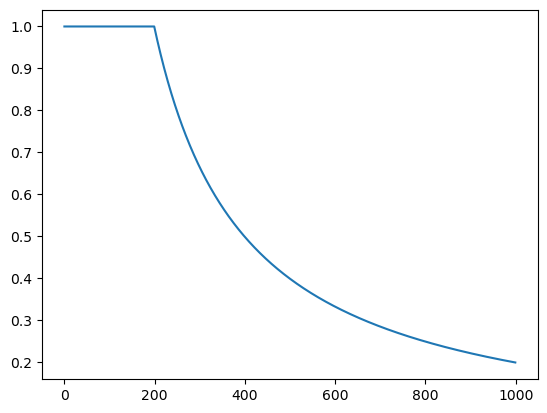

In [210]:
plt.plot(f[:1000])

In [211]:
f_pred = fraction(arg_C1_sorted,C1_sorted,els[5])


In [213]:
C_1d = np.reshape(C,(1,-1))

In [214]:
C_1d = np.reshape(C,(1,-1))
to_sort = np.argsort(C_1d)
to_sort = to_sort[0][::-1]
arg_C1 = np.zeros((N*N,2),dtype=int)
k = 0
for i in range(N):
    for j in range(N):
        arg_C1[k,0], arg_C1[k,1] = i,j 
        k+=1

arg_C1 = arg_C1[to_sort]

arg_C1[0]

array([52, 52])

In [215]:
C_ordered = np.zeros(N*N)
for i,elm in enumerate(arg_C1):
    C_ordered[i] = C[elm[0],elm[1]]

In [216]:
print(arg_C1[0:1010,:])

[[52 52]
 [97 97]
 [98 98]
 ...
 [22 64]
 [96 77]
 [77 96]]


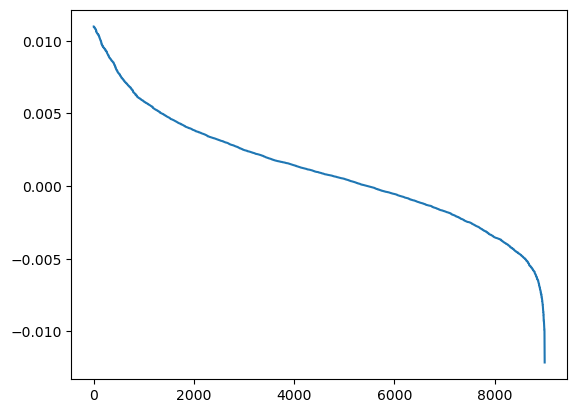

In [217]:
plt.plot(C_ordered[1000:])


In [149]:
np.arange(1000,10000)

array([1000, 1001, 1002, ..., 9997, 9998, 9999])

In [171]:
f = np.zeros(N*N-N)
for i, k in enumerate(np.arange(1000,10000)):
    to_check = arg_C1[1000:k+1,:]
    count = 0
    for elm in to_check:
        if tuple(elm) in els[0]:
            count += 1
    f[i]=(count/(i+1))

    

In [162]:
np.where(f>0)[0].shape

(6477,)

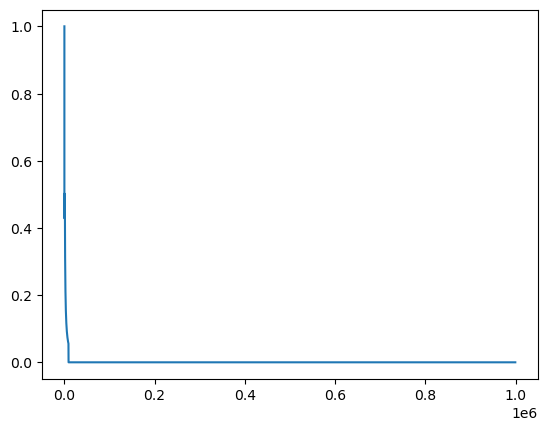

In [172]:
plt.plot(f)

In [123]:
a = np.arange(9)
a[::-1]

array([8, 7, 6, 5, 4, 3, 2, 1, 0])

In [121]:
a.reshape((1,-1))[::-1]

array([[0, 1, 2, 3, 4, 5, 6, 7, 8]])

In [218]:
J = np.linalg.inv(C)

(array([[0., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-0.1120739 ,  0.00372586,  0.11952561,  0.23532537,  0.35112512,
         0.46692488,  0.58272464,  0.69852439,  0.81432415,  0.93012391,
         1.04592366]),
 <a list of 10000 BarContainer objects>)

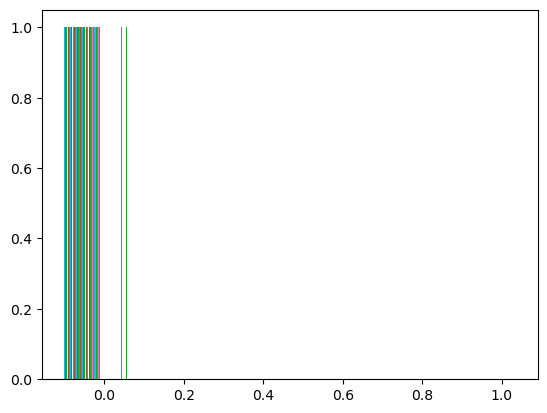

In [219]:
plt.hist(J.reshape(1,-1))

### 3

In [220]:
C_1d = []
edges = []
for i in range(N):
    for j in range(i+1,N):
        C_1d.append(C[i,j])
        edges.append([i,j])
C_1d = np.array(C_1d)
edges = np.array(edges)

In [221]:
edges.shape, C_1d.shape
C_in = []
J_in = []
C_out = []
J_out = []
for i, edge in enumerate(edges):
    if tuple(edge) in els[-1]:
        C_in.append(C_1d[i])
        J_in.append(J[edge[0],edge[1]])
    else:
        C_out.append(C_1d[i])
        J_out.append(J[edge[0],edge[1]])

(array([  5.,  14.,  33.,  76., 161., 285., 412., 561., 648., 697., 619.,
        461., 346., 217., 122.,  54.,  27.,   5.,   6.,   1.]),
 array([-0.01173191, -0.01046804, -0.00920416, -0.00794029, -0.00667642,
        -0.00541255, -0.00414867, -0.0028848 , -0.00162093, -0.00035705,
         0.00090682,  0.00217069,  0.00343456,  0.00469844,  0.00596231,
         0.00722618,  0.00849005,  0.00975393,  0.0110178 ,  0.01228167,
         0.01354555]),
 <BarContainer object of 20 artists>)

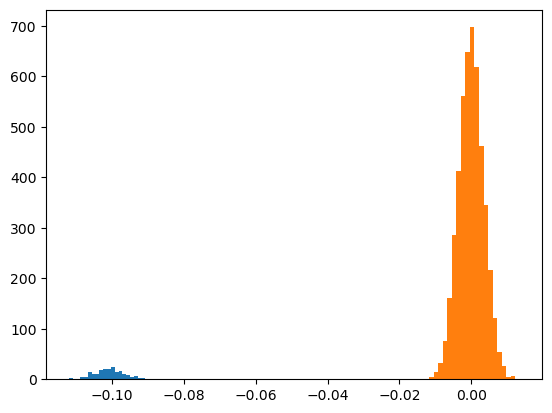

In [224]:
plt.hist(J_in,bins=20)
plt.hist(J_out,bins=20)

(array([  5.,  14.,  33.,  76., 161., 285., 412., 561., 648., 697., 619.,
        461., 346., 217., 122.,  54.,  27.,   5.,   6.,   1.]),
 array([-0.01173191, -0.01046804, -0.00920416, -0.00794029, -0.00667642,
        -0.00541255, -0.00414867, -0.0028848 , -0.00162093, -0.00035705,
         0.00090682,  0.00217069,  0.00343456,  0.00469844,  0.00596231,
         0.00722618,  0.00849005,  0.00975393,  0.0110178 ,  0.01228167,
         0.01354555]),
 <BarContainer object of 20 artists>)

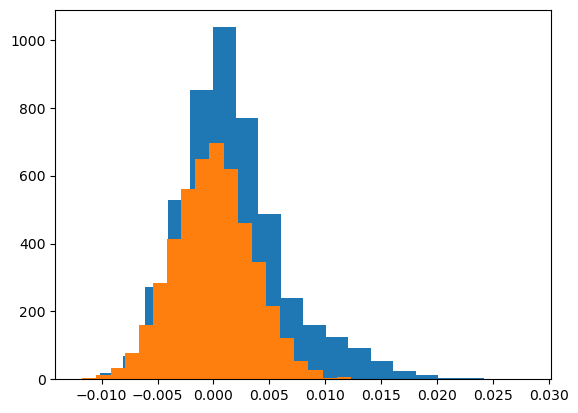

In [225]:
plt.hist(C_out,bins=20)
plt.hist(J_out,bins=20)